In [1]:
%cd /teamspace/studios/this_studio/2024/07/store_demand_forecasting/code/

/teamspace/studios/this_studio/2024/07/store_demand_forecasting/code


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsforecast as sf
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series

In [3]:
train_df = pd.read_csv('../data/train.csv')

In [5]:
train_df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [6]:
train_df['store'].nunique()

10

In [7]:
train_df['item'].nunique()

50

In [16]:
def process_data(data):
    df = data.copy()
    df['date']= pd.to_datetime(df['date'])
    return df

In [18]:
train_df = process_data(train_df)

In [33]:
def plot_ts(df,store_id,item_id):
    df1= df.loc[(df['store']==store_id)&(df['item']==item_id)]
    plt.figure(figsize=(12,4))
    df1.set_index('date')['sales'].plot()
    plt.show()

In [38]:
train_df.groupby('store')['item'].unique()

store
1     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
2     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
3     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
4     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
6     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
7     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
8     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
9     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
10    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Name: item, dtype: object

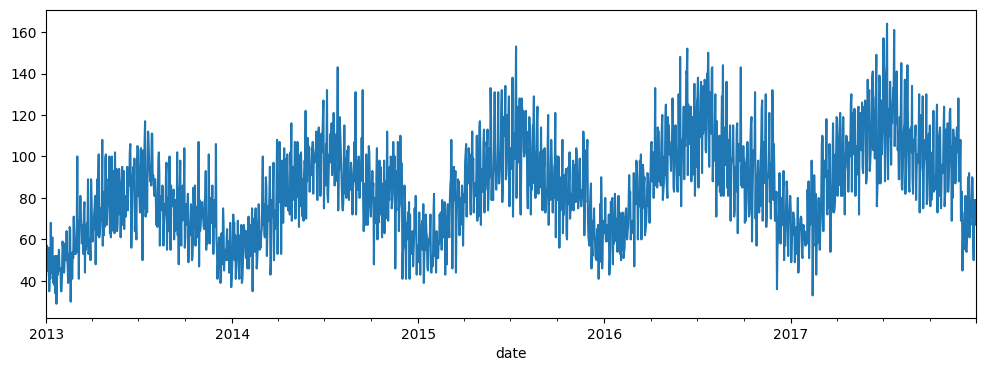

In [39]:
plot_ts(train_df,2,50)

In [40]:
train_df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [44]:
train_df[(train_df['store']==1)&(train_df['item']==50)].rename(columns={'date':'ds','sales':'demand'})

,ds,store,item,demand
894740,2013-01-01,1,50,30
894741,2013-01-02,1,50,32
894742,2013-01-03,1,50,25
894743,2013-01-04,1,50,32
894744,2013-01-05,1,50,35
...,...,...,...,...
896561,2017-12-27,1,50,38
896562,2017-12-28,1,50,52
896563,2017-12-29,1,50,59
896564,2017-12-30,1,50,66


In [42]:
import pandas as pd
import numpy as np

def classify_time_series(df):
    """
    Classifies the time series into erratic, lumpy, or smooth based on ADI and CV2.
    
    Parameters:
    df (DataFrame): DataFrame with columns 'ds' (datetime) and 'demand' (sales)
    
    Returns:
    dict: A dictionary with 'ADI', 'CV2', and 'Classification'
    """
    # Calculate the intervals between non-zero demands
    df = df.sort_values('ds')
    demand_intervals = df[df['demand'] > 0]['ds'].diff().dropna().dt.days
    
    # Calculate ADI
    ADI = demand_intervals.mean()
    
    # Calculate CV2
    mean_demand = df['demand'].mean()
    std_demand = df['demand'].std()
    CV2 = (std_demand / mean_demand) ** 2
    
    # Classification based on ADI and CV2
    if ADI > 1.32 and CV2 > 0.49:
        classification = 'Lumpy'
    elif ADI <= 1.32 and CV2 > 0.49:
        classification = 'Erratic'
    else:
        classification = 'Smooth'
    
    return {'ADI': ADI, 'CV2': CV2, 'Classification': classification}

In [45]:
classify_time_series(train_df[(train_df['store']==1)&(train_df['item']==50)].rename(columns={'date':'ds','sales':'demand'}))

{'ADI': 1.0, 'CV2': 0.07618943851231015, 'Classification': 'Smooth'}